In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Concatenate, Dropout

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

In [ ]:
# the simulations can be generated by data_generation_nb notebook.
simulated_data = np.load('./generated_data/simulated_data_020124_150K.npy')

In [2]:
os.environ['PYTHONHASHSEED']=str(159)

np.random.seed(159)
tf.random.set_seed(159)

In [4]:
# Split the data
initial_state = simulated_data[:, 0]
final_state = simulated_data[:, 1]

# Compute the mean and std of the initial and final states
initial_state_mean, initial_state_std = np.mean(initial_state), np.std(initial_state)
final_state_mean, final_state_std = np.mean(final_state), np.std(final_state)

# Normalize the initial and final states
initial_state = (initial_state - initial_state_mean) / initial_state_std
final_state = (final_state - final_state_mean) / final_state_std

# Select one simulation's initial and final states
initial_conditions = initial_state[0]
final_density = final_state[0]

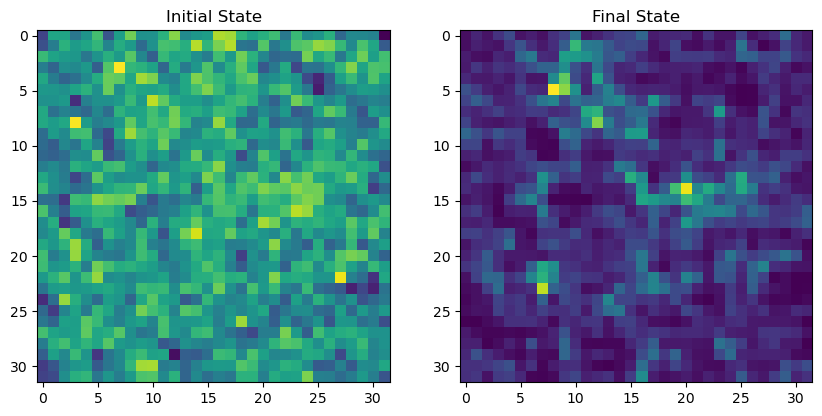

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# initial state and final state
axes[0].imshow(initial_conditions[0], cmap='viridis')
axes[0].set_title("Initial State")

axes[1].imshow(final_density[0], cmap='viridis')  
axes[1].set_title("Final State")

plt.show()

In [5]:
# train and test
X_train, X_test, y_train, y_test  = train_test_split(initial_state, final_state, test_size=0.15, random_state=123)

# further splitting it in training and testing
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=123)

In [6]:
# Recasting dimensions to 4D tensor (suitable for 3D convolutions) with the following dimensions: 
# (batch_size, height, width, depth, num_channels)
X_train = np.reshape(X_train, (*X_train.shape, 1))
X_val = np.reshape(X_val, (*X_val.shape, 1))
X_test = np.reshape(X_test, (*X_test.shape, 1))

y_train = np.reshape(y_train, (*y_train.shape, 1))
y_val = np.reshape(y_val, (*y_val.shape, 1))
y_test = np.reshape(y_test, (*y_test.shape, 1))

In [8]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test.shape, y_test.shape

((114750, 32, 32, 32, 1),
 (12750, 32, 32, 32, 1),
 (114750, 32, 32, 32, 1),
 (12750, 32, 32, 32, 1),
 (22500, 32, 32, 32, 1),
 (22500, 32, 32, 32, 1))

In [9]:
# saving in case the instance failed
# np.save('X_unet_test.npy', X_test)
# np.save('y_unet_test.npy', y_test)

## Instantiate UNet model

In [3]:
# Parameters
Ngrid = 32

In [8]:
def create_volumetric_unet(input_shape, num_classes):
    # input layer
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(drop1)
    
    conv2 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(drop2)

    conv3 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv3)

    # Expansive path
    up1 = Concatenate()([UpSampling3D(size=(2, 2, 2))(conv3), conv2])
    conv4 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up1)
    conv4 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv4)

    up2 = Concatenate()([UpSampling3D(size=(2, 2, 2))(conv4), conv1])
    conv5 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up2)
    conv5 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv5)

    # Final conv layer to reduce channel dimensionality to number of classes
    conv_final = Conv3D(num_classes, (1, 1, 1))(conv5)

    return Model(inputs=[inputs], outputs=[conv_final])

In [12]:
unet_model = create_volumetric_unet((Ngrid, Ngrid, Ngrid, 1), num_classes=1)

2024-01-03 16:23:10.566743: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-03 16:23:10.989556: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [13]:
# Compile the model
unet_model.compile(optimizer=Adam(),
                   loss='mse',
                   run_eagerly=True)

In [11]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1


2024-01-05 10:32:09.081742: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-05 10:32:14.223074: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0


tf.Tensor(1698.7346, shape=(), dtype=float32)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
# Train the model
history = unet_model.fit(x=X_train,
                    y=y_train,
                    validation_data=(X_val, y_val),
                    batch_size=32, 
                    epochs=25,
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/25


2024-01-03 16:23:25.984381: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2024-01-03 16:23:28.212741: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3586/3586 [==============================] - ETA: 0s - loss: 0.3791
Epoch 1: loss improved from inf to 0.37910, saving model to unet.hdf5
3586/3586 [==============================] - 483s 133ms/step - loss: 0.3791 - val_loss: 0.3253 - lr: 0.0010
Epoch 2/25


2024-01-03 16:31:28.905288: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-01-03 16:31:28.905701: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


   1/3586 [..............................] - ETA: 16:10 - loss: 0.3310

2024-01-03 16:31:29.176419: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-01-03 16:31:29.176753: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


   2/3586 [..............................] - ETA: 16:19 - loss: 0.3240

2024-01-03 16:31:29.449679: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-01-03 16:31:29.449978: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


   3/3586 [..............................] - ETA: 16:20 - loss: 0.3274

2024-01-03 16:31:29.724008: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-01-03 16:31:29.724327: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


   4/3586 [..............................] - ETA: 16:20 - loss: 0.3268

2024-01-03 16:31:29.997307: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-01-03 16:31:29.997674: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


3586/3586 [==============================] - ETA: 0s - loss: 0.3192
Epoch 2: loss improved from 0.37910 to 0.31918, saving model to unet.hdf5
3586/3586 [==============================] - 996s 278ms/step - loss: 0.3192 - val_loss: 0.3174 - lr: 0.0010
Epoch 3/25
3586/3586 [==============================] - ETA: 0s - loss: 0.3130
Epoch 3: loss improved from 0.31918 to 0.31304, saving model to unet.hdf5
3586/3586 [==============================] - 997s 278ms/step - loss: 0.3130 - val_loss: 0.3103 - lr: 0.0010
Epoch 4/25
3586/3586 [==============================] - ETA: 0s - loss: 0.3098
Epoch 4: loss improved from 0.31304 to 0.30978, saving model to unet.hdf5
3586/3586 [==============================] - 997s 278ms/step - loss: 0.3098 - val_loss: 0.3075 - lr: 0.0010
Epoch 5/25
3586/3586 [==============================] - ETA: 0s - loss: 0.3072
Epoch 5: loss improved from 0.30978 to 0.30719, saving model to unet.hdf5
3586/3586 [==============================] - 997s 278ms/step - loss: 0.3072

In [4]:
# Load the model in case the instance crashed
unet_model = load_model('unet.hdf5')

2024-01-05 10:54:24.187562: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-05 10:54:24.615344: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [13]:
# Continue training
history = unet_model.fit(x=X_train,
                         y=y_train,
                         validation_data=(X_val, y_val),
                         batch_size=32, 
                         epochs=50, 
                         callbacks=[early_stopping, reduce_lr, model_checkpoint],
                         initial_epoch=25)

Epoch 26/50


2024-01-04 23:21:21.461924: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


3586/3586 [==============================] - ETA: 0s - loss: 0.2945
Epoch 26: loss improved from inf to 0.29450, saving model to unet.hdf5
3586/3586 [==============================] - 472s 125ms/step - loss: 0.2945 - val_loss: 0.2953 - lr: 0.0010
Epoch 27/50
3586/3586 [==============================] - ETA: 0s - loss: 0.2943
Epoch 27: loss improved from 0.29450 to 0.29435, saving model to unet.hdf5
3586/3586 [==============================] - 444s 124ms/step - loss: 0.2943 - val_loss: 0.2946 - lr: 0.0010
Epoch 28/50
3586/3586 [==============================] - ETA: 0s - loss: 0.2942
Epoch 28: loss improved from 0.29435 to 0.29417, saving model to unet.hdf5
3586/3586 [==============================] - 445s 124ms/step - loss: 0.2942 - val_loss: 0.2935 - lr: 0.0010
Epoch 29/50
3586/3586 [==============================] - ETA: 0s - loss: 0.2940
Epoch 29: loss improved from 0.29417 to 0.29403, saving model to unet.hdf5
3586/3586 [==============================] - 446s 124ms/step - loss: 0.2

In [5]:
X_test = np.load('X_unet_test.npy')
y_test = np.load('y_unet_test.npy')

In [6]:
# Evaluate the model
eval_results = unet_model.evaluate(x=X_test, y=y_test)
print(f"Evaluation Results:{eval_results}")

2024-01-05 10:56:46.914511: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


704/704 [==============================] - 28s 35ms/step - loss: 0.2924
Evaluation Results:0.2923876941204071


In [7]:
# Predict with the model
predictions = unet_model.predict(X_test)
predictions.shape

(22500, 32, 32, 32, 1)

In [8]:
vmin = min(np.min(predictions), np.min(X_test))
vmax = max(np.max(predictions), np.max(X_test))

vmin, vmax

(-6.37655171866268, 28.057322)

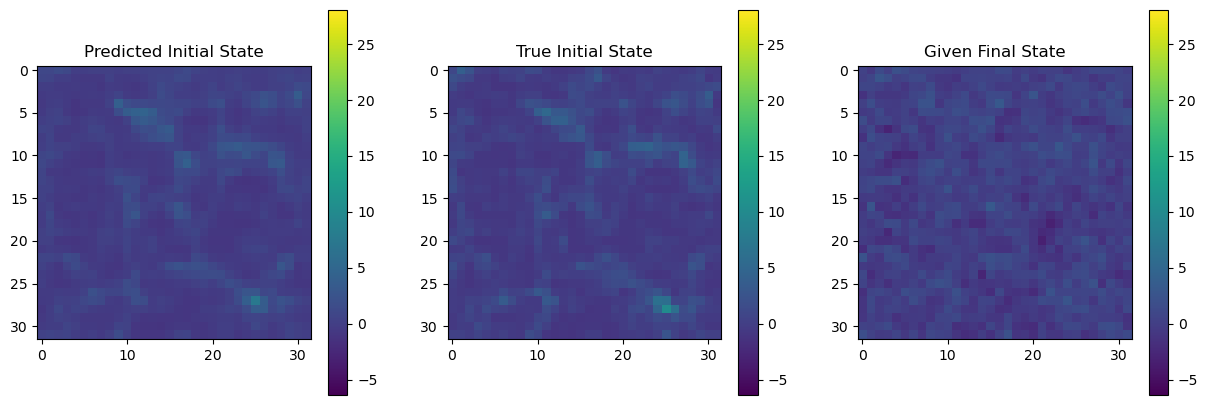

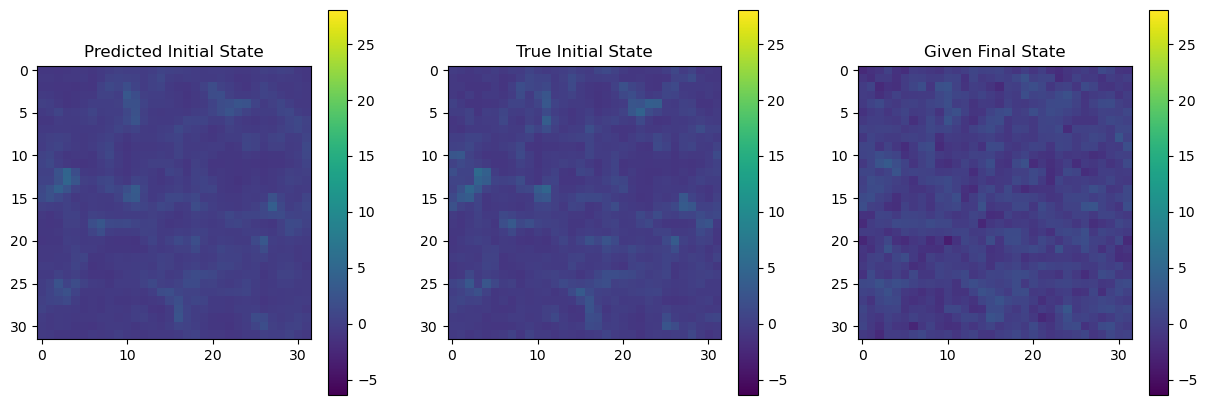

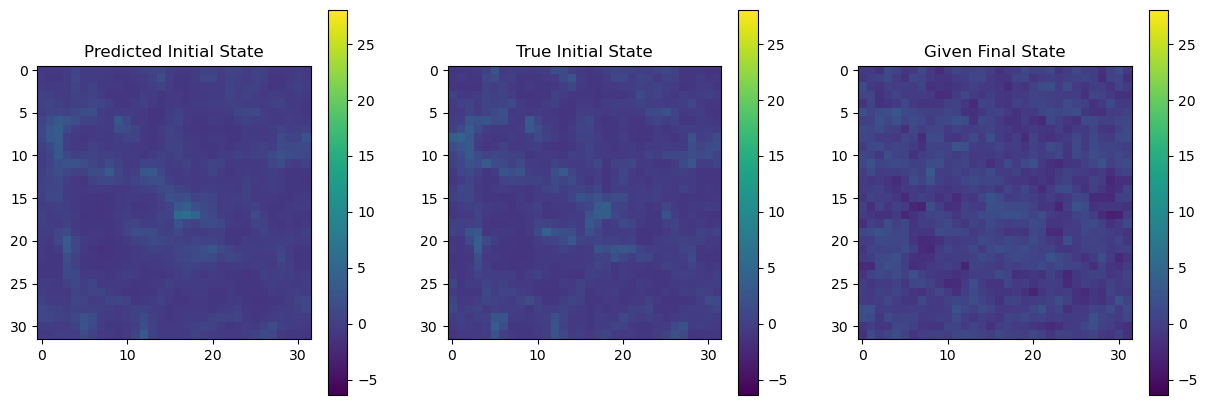

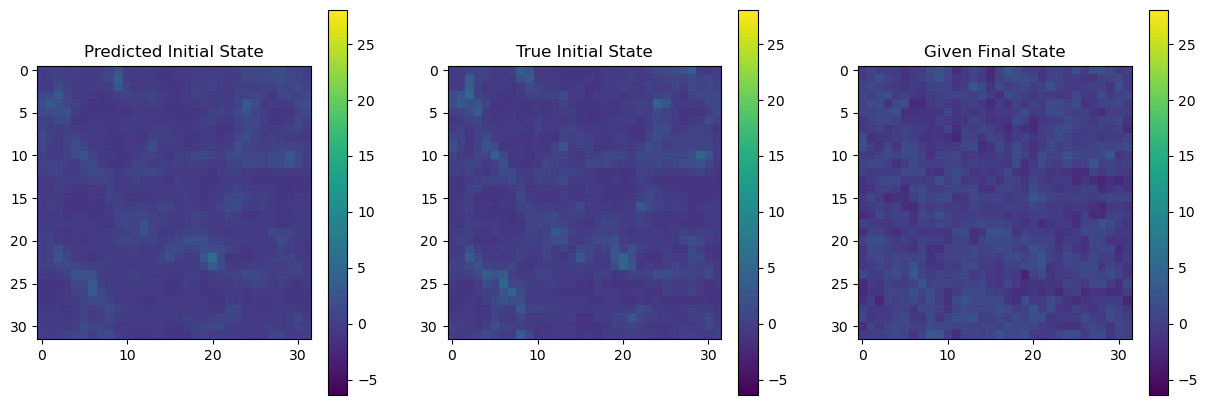

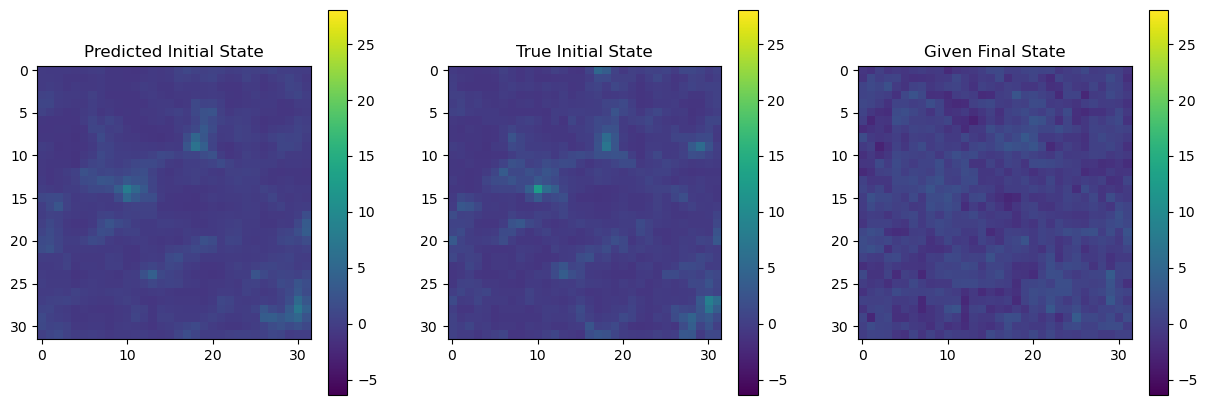

In [9]:
for test_index in range(5):  # Plot first 5 test cases
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot predicted initial state
    im = axs[0].imshow(predictions[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], vmin=vmin, vmax=vmax)
    axs[0].set_title('Predicted Initial State')
    fig.colorbar(im, ax=axs[0])

    # Plot true initial state
    im = axs[1].imshow(y_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], vmin=vmin, vmax=vmax)
    axs[1].set_title('True Initial State')
    fig.colorbar(im, ax=axs[1])

    # Plot given final state 
    im = axs[2].imshow(X_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], vmin=vmin, vmax=vmax)
    axs[2].set_title('Given Final State')
    fig.colorbar(im, ax=axs[2])

    plt.show()

In [10]:
# calculating the error metrics
mse = mean_squared_error(y_test.flatten(), predictions.flatten())
mae = mean_absolute_error(y_test.flatten(), predictions.flatten())

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.2923875313555835
Mean Absolute Error (MAE): 0.35997149405602463


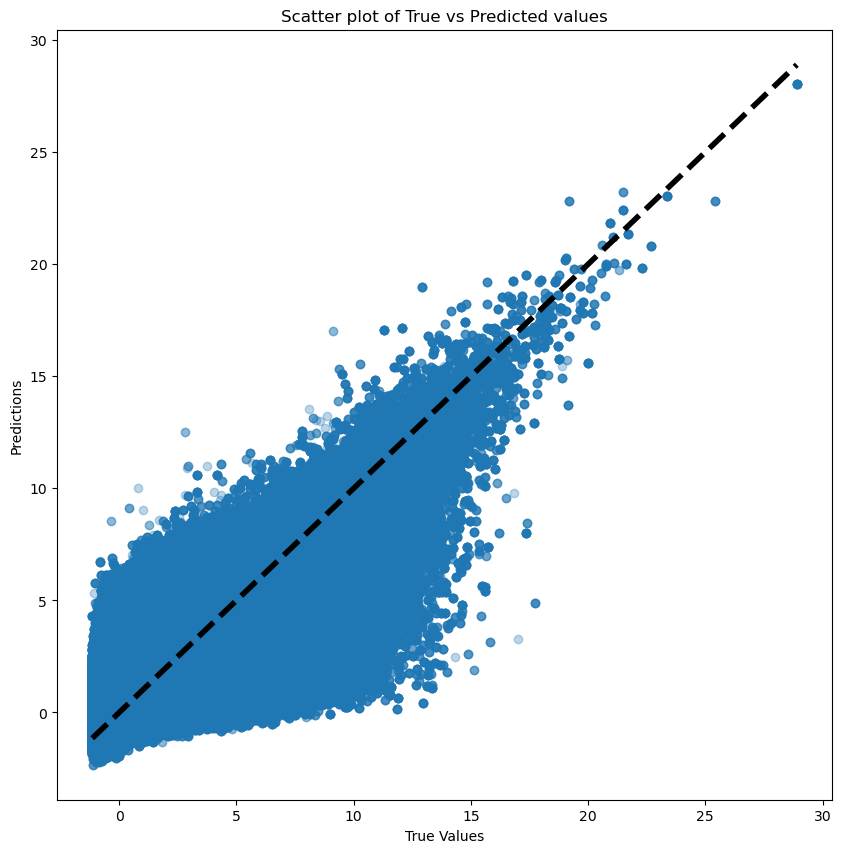

In [11]:
plt.figure(figsize=(10,10))
plt.scatter(y_test.flatten(), predictions.flatten(), alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter plot of True vs Predicted values')
plt.show()